# Climate Misinfo - Notebook 2

Notebook by Jenna Sparks

In [23]:
# Load some EDA libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load some prelim ML libs
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import TextVectorization, Dense, Embedding, Input, Concatenate
from tensorflow.keras.models import Model

# Balance the categories
from sklearn.utils import resample

In [24]:
df = pd.read_parquet("hf://datasets/QuotaClimat/frugalaichallenge-text-train/train.parquet")

## General quality check

In [25]:
df.head()

,quote,label,source,url,language,subsource,id
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None
4,It's going to be 42 here today and the hottest...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None


## ML Baseline 2

### Prep Data

In [26]:
# Convert labels to binary
df['binary_label'] = (df['label'] == '0_not_relevant').astype(int)

In [27]:
# Split data into two groups
majority_class = df[df['binary_label'] == 1]
minority_class = df[df['binary_label'] == 0]
df.head()

,quote,label,source,url,language,subsource,id,binary_label
0,"There is clear, compelling evidence that many ...",5_science_unreliable,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,0
1,"For most of the Holocene (last 10k years), sea...",1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test1,None,0
2,"China, which hosts U.N. climate talks next wee...",4_solutions_harmful_unnecessary,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,0
3,And the fabricated documents (which Dr. Mann a...,0_not_relevant,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,1
4,It's going to be 42 here today and the hottest...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None,0


### Resample!

In [28]:
# Balance the classes using undersampling
# Undersample the majority class
majority_class_downsampled = resample(
    majority_class,
    replace=True,  # Sample with replacement
    n_samples=len(minority_class),
    random_state=42
)

In [29]:
# Combine the two classes
balanced_df = pd.concat([majority_class_downsampled, minority_class])

# Shuffle the dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [30]:
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Verify the shapes
train_df.shape, val_df.shape, test_df.shape

((4263, 8), (914, 8), (914, 8))

In [31]:
# Combine text fields into one for simplicity
# Text features - use all the features?
text_features = ['quote', 'source', 'url', 'language', 'subsource', 'id']

train_df['combined_text'] = train_df[text_features].fillna('').agg(' '.join, axis=1)
val_df['combined_text'] = val_df[text_features].fillna('').agg(' '.join, axis=1)
test_df['combined_text'] = test_df[text_features].fillna('').agg(' '.join, axis=1)

# Verify new column
train_df.head()

,quote,label,source,url,language,subsource,id,binary_label,combined_text
6216,"On the science of global climate change, I’m a...",5_science_unreliable,Desmog,https://www.desmog.com/robert-bryce/,en,None,None,0,"On the science of global climate change, I’m a..."
690,the glaciers of Geenland have shown substantia...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,hamburg_test3,None,0,the glaciers of Geenland have shown substantia...
5824,"This, it seems to me, is the most sensible way...",4_solutions_harmful_unnecessary,Desmog,https://www.desmog.com/jeremy-clarkson/,en,None,None,0,"This, it seems to me, is the most sensible way..."
1773,Earth to looney left. A record cold winter is ...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,0,Earth to looney left. A record cold winter is ...
602,There hasn't been any sea level rise in the Sa...,1_not_happening,FLICC,https://huggingface.co/datasets/fzanartu/FLICC...,en,CARDS,None,0,There hasn't been any sea level rise in the Sa...


### Vectorize

In [32]:
# Standardize input
max_vocab_size = 10000
max_sequence_length = 200

vectorizer = TextVectorization(max_tokens=max_vocab_size, output_sequence_length=max_sequence_length)
vectorizer.adapt(train_df['combined_text'].values)

In [33]:
# Model output layer for binary classification
text_input = Input(shape=(1,), dtype=tf.string, name="text")
x = vectorizer(text_input)
x = Embedding(input_dim=max_vocab_size, output_dim=64)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = Dense(32, activation='relu')(x)

In [34]:
# Binary classification output
output = Dense(1, activation='sigmoid', name="label")(x)

# Model definition
model = Model(inputs=text_input, outputs=output)
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

### Train Model

In [37]:
train_df = train_df.fillna('')
val_df = val_df.fillna('')

history = model.fit(train_df['combined_text'], train_df['binary_label'],
                    validation_data=(val_df['combined_text'], val_df['binary_label']),
                    epochs=5)

Epoch 1/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7161 - auc_1: 0.5168 - loss: 0.6053 - precision_1: 0.4535 - recall_1: 0.1059 - val_accuracy: 0.7538 - val_auc_1: 0.5264 - val_loss: 0.5698 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7300 - auc_1: 0.5384 - loss: 0.5820 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.7538 - val_auc_1: 0.6580 - val_loss: 0.5557 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7249 - auc_1: 0.6253 - loss: 0.5745 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.7538 - val_auc_1: 0.7928 - val_loss: 0.5281 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/5
134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7202 - auc_1: 0.6961 - loss: 0.5598 - precision_1: 0.1704 - recall_1: 2.9040e-04 - val_accuracy: 0.7615 - val_auc_1: 0.8396 - val_lo

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7772 - auc_1: 0.8409 - loss: 0.4285 - precision_1: 0.7089 - recall_1: 0.1736
Validation Accuracy: 0.79
Validation Precision: 0.75
Validation Recall: 0.21
Validation AUC: 0.84


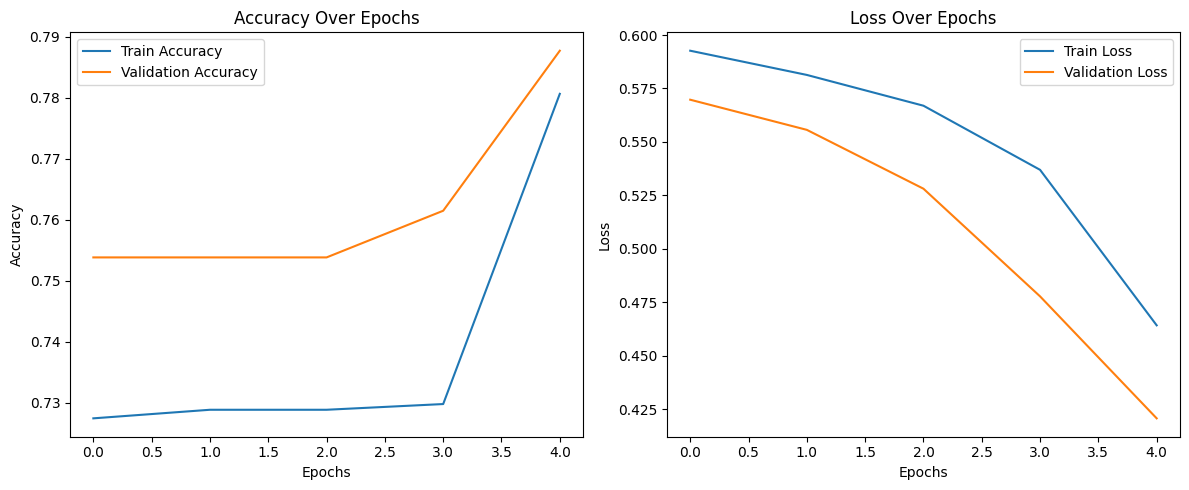

In [39]:
# Evaluate on the validation set
val_loss, val_acc, val_precision, val_recall, val_auc = model.evaluate(val_df['combined_text'], val_df['binary_label']) # Pass the 'combined_text' and 'binary_label' columns
print(f"Validation Accuracy: {val_acc:.2f}")
print(f"Validation Precision: {val_precision:.2f}")
print(f"Validation Recall: {val_recall:.2f}")
print(f"Validation AUC: {val_auc:.2f}")

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)